In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [77]:
df_train = pd.read_csv('/kaggle/input/train-data/Train.csv')
df_train.head(10)

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
5,6,"Covid Act Now found ""on average each person in...",real
6,7,If you tested positive for #COVID19 and have n...,real
7,8,Obama Calls Trump’s Coronavirus Response A Cha...,fake
8,9,"???Clearly, the Obama administration did not l...",fake
9,10,Retraction—Hydroxychloroquine or chloroquine w...,fake


In [78]:
df_train['label'] = df_train['label'].\
    apply(lambda x: 0 if x == 'real' else 1)
df_train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,0
1,2,States reported 1121 deaths a small rise from ...,0
2,3,Politically Correct Woman (Almost) Uses Pandem...,1
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,0
4,5,Populous states can generate large case counts...,0


In [5]:
df_train['tweet'][89]

'📢#CoronaVirusUpdates: 📍#COVID19 India Tracker (As on 7 September 2020 08:00 AM) ➡️Confirmed cases: 4204613 ➡️Recovered: 3250429 (77.3%)👍 ➡️Active cases: 882542 (21.0%) ➡️Deaths: 71642 (1.7%) #IndiaFightsCorona #IndiaWillWin #StaySafe Via @MoHFW_INDIA https://t.co/WVQslxqBPC'

In [79]:


import emoji

def replace_emojis_with_text(input_text):
    
    output_text = emoji.demojize(input_text)

    return output_text
df_train['tweet'] = df_train['tweet'].apply(replace_emojis_with_text)

In [7]:
df_train['tweet'][89]

':loudspeaker:#CoronaVirusUpdates: :round_pushpin:#COVID19 India Tracker (As on 7 September 2020 08:00 AM) :right_arrow:Confirmed cases: 4204613 :right_arrow:Recovered: 3250429 (77.3%):thumbs_up: :right_arrow:Active cases: 882542 (21.0%) :right_arrow:Deaths: 71642 (1.7%) #IndiaFightsCorona #IndiaWillWin #StaySafe Via @MoHFW_INDIA https://t.co/WVQslxqBPC'

# funtion for tokenization

In [21]:
# Tokenization function
def encode_data(df, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    
    for tweet in df['tweet']:
        encoded = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            truncation=True, 
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)


# load validation data

In [80]:
df_val = pd.read_csv('/kaggle/input/val-data/Val.csv')
df_val['label'] = df_val['label'].\
    apply(lambda x: 0 if x == 'real' else 1)
df_val.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,1
1,2,11 out of 13 people (from the Diamond Princess...,1
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",1
3,4,Mike Pence in RNC speech praises Donald Trump’...,1
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,0


In [81]:
df_val['tweet'] = df_val['tweet'].apply(replace_emojis_with_text)


# loading test data

In [82]:
df_test = pd.read_csv('/kaggle/input/testdata/Test (1).csv')
df_test['tweet'] = df_test['tweet'].apply(replace_emojis_with_text)


In [83]:
df_test['label'] = df_test['label'].\
    apply(lambda x: 0 if x == 'real' else 1)
df_test.head()

,id,tweet,label
0,1,Our daily update is published. States reported...,0
1,2,Alfalfa is the only cure for COVID-19.,1
2,3,President Trump Asked What He Would Do If He W...,1
3,4,States reported 630 deaths. We are still seein...,0
4,5,This is the sixth time a global health emergen...,0


In [84]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')


In [15]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-06-10 14:07:45.797732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 14:07:45.797835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 14:07:45.925303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1


In [16]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import pandas as pd



tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def encode_data(df, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    
    for tweet in df['tweet']:
        encoded = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            truncation=True, 
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

train_input_ids, train_attention_masks = encode_data(df_train, tokenizer)
val_input_ids, val_attention_masks = encode_data(df_val, tokenizer)

train_labels = tf.convert_to_tensor(df_train['label'])
val_labels = tf.convert_to_tensor(df_val['label'])

input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)
cls_output = bert_output.last_hidden_state[:, 0, :]  # CLS token

dense = tf.keras.layers.Dense(1, activation='sigmoid')(cls_output)
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=dense)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist_model = model.fit([train_input_ids, train_attention_masks], train_labels,
          validation_data=([val_input_ids, val_attention_masks], val_labels),
          epochs=3,
          batch_size=4)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3


I0000 00:00:1718028811.925111     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1605/1605 [==============================] - 237s 103ms/step - loss: 0.1497 - accuracy: 0.9421 - val_loss: 0.0798 - val_accuracy: 0.9692
Epoch 2/3
1605/1605 [==============================] - 145s 90ms/step - loss: 0.0419 - accuracy: 0.9861 - val_loss: 0.0725 - val_accuracy: 0.9766
Epoch 3/3
1605/1605 [==============================] - 144s 90ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0931 - val_accuracy: 0.9752


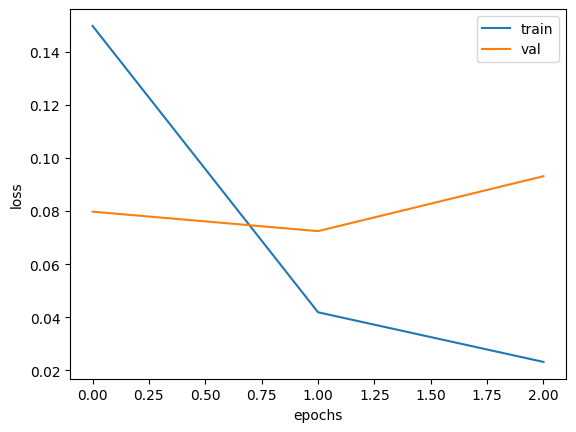

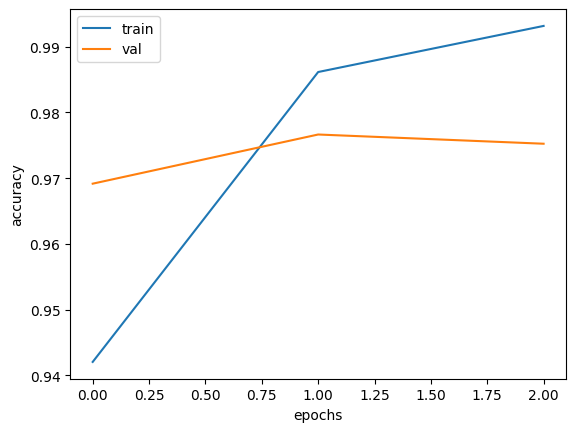

In [17]:
plt.plot(hist_model.history['loss'], label='train')
plt.plot(hist_model.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

plt.plot(hist_model.history['accuracy'], label='train')
plt.plot(hist_model.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.xlabel('epochs')


plt.legend()
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

test_input_ids, test_attention_masks = encode_data(df_test, tokenizer)
test_labels = df_test['label'].values

raw_predictions = model.predict([test_input_ids, test_attention_masks])
predictions = tf.squeeze(tf.round(raw_predictions)).numpy()

conf_matrix = confusion_matrix(test_labels, predictions)

f1 = f1_score(test_labels, predictions)

accuracy = accuracy_score(test_labels, predictions)

print('Confusion Matrix:\n', conf_matrix)
print('F1 Score:', f1)
print('Accuracy:', accuracy)



67/67 [==============================] - 22s 162ms/step
Confusion Matrix:
 [[1112    8]
 [  36  984]]
F1 Score: 0.9781312127236581
Accuracy: 0.9794392523364486


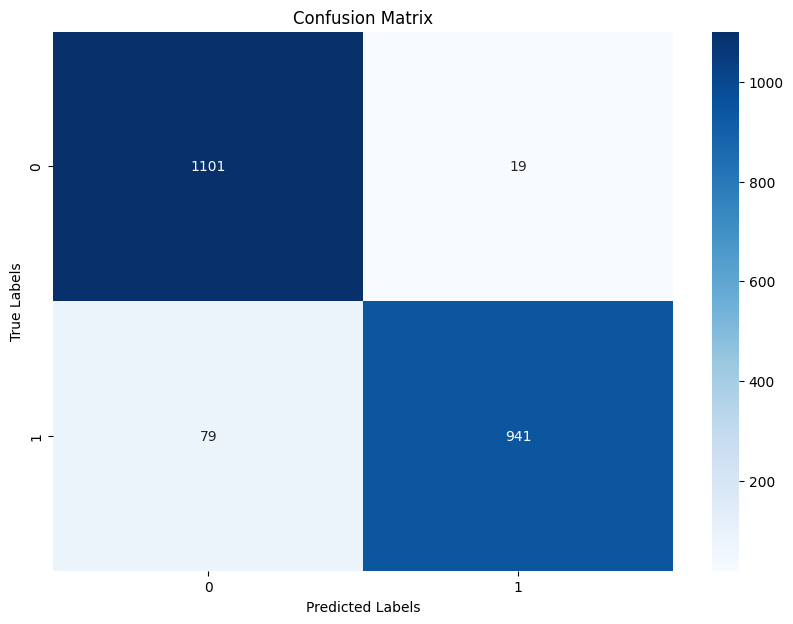

In [33]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# this implement model2 with Bert layer and use BiGRU layer

In [20]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


def encode_data(df, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    
    for tweet in df['tweet']:
        encoded = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            truncation=True, 
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

train_input_ids, train_attention_masks = encode_data(df_train, tokenizer)
val_input_ids, val_attention_masks = encode_data(df_val, tokenizer)

train_labels = tf.convert_to_tensor(df_train['label'])
val_labels = tf.convert_to_tensor(df_val['label'])

input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')


bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]

gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=False))(bert_output)

dense = tf.keras.layers.Dense(1, activation='sigmoid')(gru_layer)
model2_BiGRU = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=dense)

model2_BiGRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
hist_model_BiGRU = model2_BiGRU.fit([train_input_ids, train_attention_masks], train_labels,
          validation_data=([val_input_ids, val_attention_masks], val_labels),
          epochs=3,
          batch_size=4)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1605/1605 [==============================] - 244s 114ms/step - loss: 0.1580 - accuracy: 0.9357 - val_loss: 0.0721 - val_accuracy: 0.9724
Epoch 2/3
1605/1605 [==============================] - 163s 102ms/step - loss: 0.0495 - accuracy: 0.9818 - val_loss: 0.0513 - val_accuracy: 0.9822
Epoch 3/3
1605/1605 [==============================] - 162s 101ms/step - loss: 0.0182 - accuracy: 0.9935 - val_loss: 0.0867 - val_accuracy: 0.9757


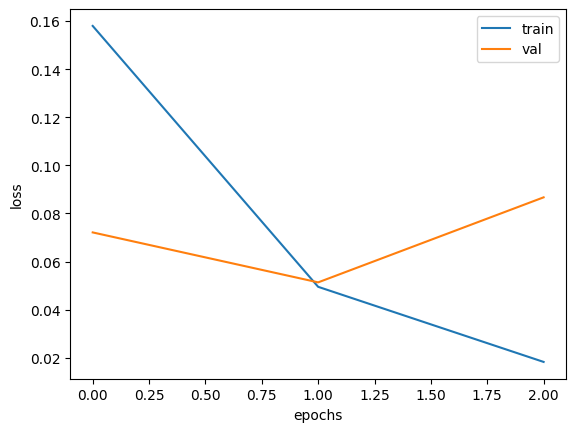

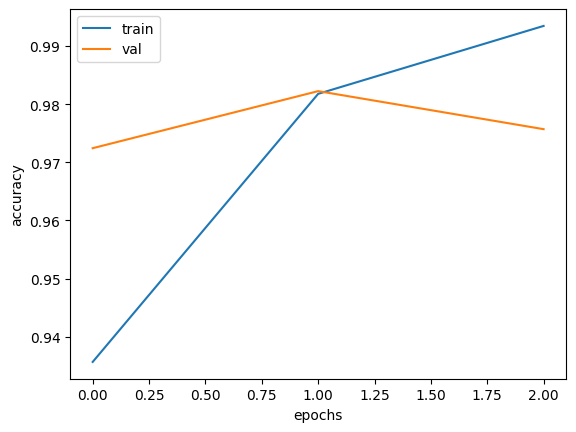

In [22]:
plt.plot(hist_model_BiGRU.history['loss'], label='train')
plt.plot(hist_model_BiGRU.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

plt.plot(hist_model_BiGRU.history['accuracy'], label='train')
plt.plot(hist_model_BiGRU.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.xlabel('epochs')


plt.legend()
plt.show()

67/67 [==============================] - 24s 167ms/step
Confusion Matrix:
 [[1111    9]
 [  50  970]]
F1 Score: 0.9704852426213106
Accuracy: 0.9724299065420561


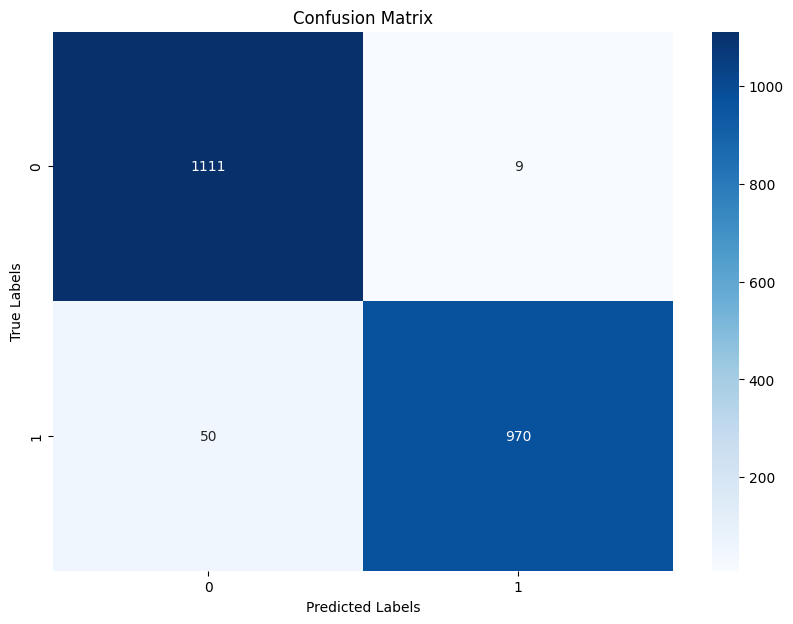

In [23]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

test_input_ids, test_attention_masks = encode_data(df_test, tokenizer)
test_labels = df_test['label'].values

raw_predictions = model2_BiGRU.predict([test_input_ids, test_attention_masks])
predictions = tf.squeeze(tf.round(raw_predictions)).numpy()

conf_matrix = confusion_matrix(test_labels, predictions)

f1 = f1_score(test_labels, predictions)

accuracy = accuracy_score(test_labels, predictions)

print('Confusion Matrix:\n', conf_matrix)
print('F1 Score:', f1)
print('Accuracy:', accuracy)

import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# model3 with CT_Bert model and BiGRU layer

In [24]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert')
bert_model = TFBertModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert')

bert_model.trainable = True

def encode_data(df, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    
    for tweet in df['tweet']:
        encoded = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            truncation=True, 
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

train_input_ids, train_attention_masks = encode_data(df_train, tokenizer)
val_input_ids, val_attention_masks = encode_data(df_val, tokenizer)

train_labels = tf.convert_to_tensor(df_train['label'])
val_labels = tf.convert_to_tensor(df_val['label'])

input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]

gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=False))(bert_output)

dense = tf.keras.layers.Dense(1, activation='sigmoid')(gru_layer)
model3_CT_Bert = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=dense)

# Compile the model
model3_CT_Bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Train the model
with tf.device('/GPU:0'):
    hist_model3_CT_Bert = model3_CT_Bert.fit([train_input_ids, train_attention_masks], train_labels,
                                             validation_data=([val_input_ids, val_attention_masks], val_labels),
                                             epochs=3,
                                             batch_size=4)




vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_ma

Epoch 1/3
1605/1605 [==============================] - 599s 299ms/step - loss: 0.1239 - accuracy: 0.9565 - val_loss: 0.0890 - val_accuracy: 0.9659
Epoch 2/3
1605/1605 [==============================] - 451s 281ms/step - loss: 0.0394 - accuracy: 0.9855 - val_loss: 0.1299 - val_accuracy: 0.9659
Epoch 3/3
1605/1605 [==============================] - 453s 282ms/step - loss: 0.0405 - accuracy: 0.9886 - val_loss: 0.0781 - val_accuracy: 0.9752


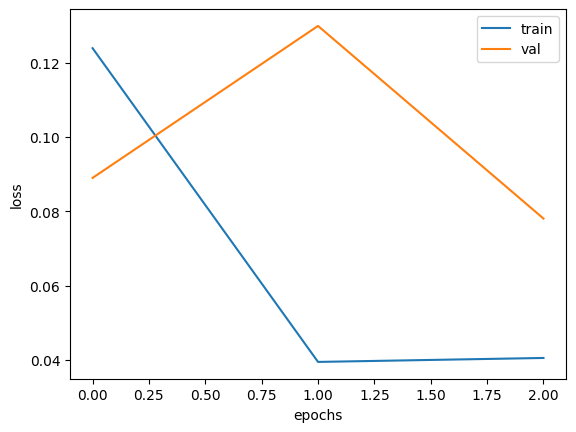

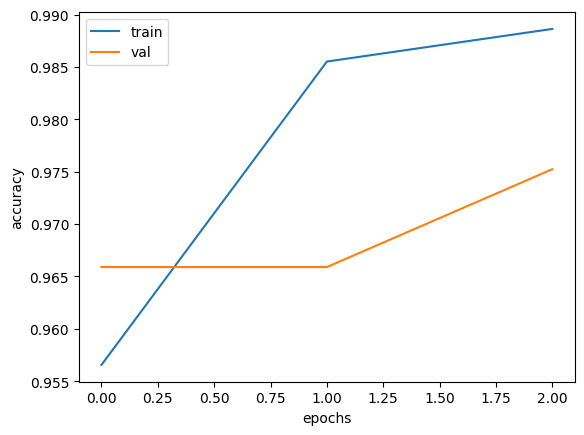

In [26]:
plt.plot(hist_model3_CT_Bert.history['loss'], label='train')
plt.plot(hist_model3_CT_Bert.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

plt.plot(hist_model3_CT_Bert.history['accuracy'], label='train')
plt.plot(hist_model3_CT_Bert.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.xlabel('epochs')


plt.legend()
plt.show()

67/67 [==============================] - 58s 508ms/step
Confusion Matrix:
 [[1088   32]
 [  20 1000]]
F1 Score: 0.9746588693957114
Accuracy: 0.9757009345794393


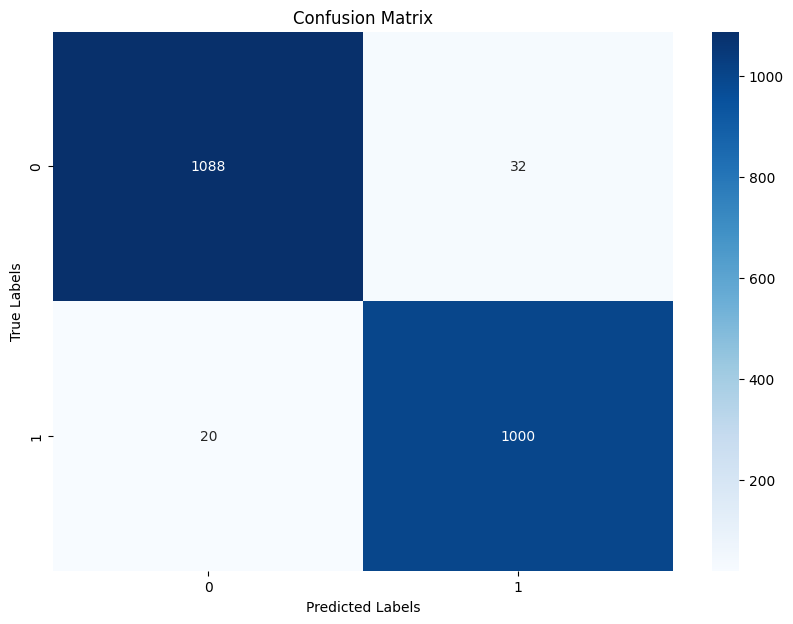

In [27]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

test_input_ids, test_attention_masks = encode_data(df_test, tokenizer)
test_labels = df_test['label'].values

raw_predictions = model3_CT_Bert.predict([test_input_ids, test_attention_masks])
predictions = tf.squeeze(tf.round(raw_predictions)).numpy()

conf_matrix = confusion_matrix(test_labels, predictions)

f1 = f1_score(test_labels, predictions)

# Calculate the accuracy
accuracy = accuracy_score(test_labels, predictions)

print('Confusion Matrix:\n', conf_matrix)
print('F1 Score:', f1)
print('Accuracy:', accuracy)

import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Section feature Base

# model 1

In [86]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

bert_model.trainable = False
def encode_data(df, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    
    for tweet in df['tweet']:
        encoded = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            truncation=True, 
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

train_input_ids, train_attention_masks = encode_data(df_train, tokenizer)
val_input_ids, val_attention_masks = encode_data(df_val, tokenizer)

train_labels = tf.convert_to_tensor(df_train['label'])
val_labels = tf.convert_to_tensor(df_val['label'])

# Build the model
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)
cls_output = bert_output.last_hidden_state[:, 0, :]  

dense = tf.keras.layers.Dense(1, activation='sigmoid')(cls_output)
model1_feature_based = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=dense)

model1_feature_based.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
hist_model1_feature_based = model1_feature_based.fit([train_input_ids, train_attention_masks], train_labels,
          validation_data=([val_input_ids, val_attention_masks], val_labels),
          epochs=3,
          batch_size=4)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1605/1605 [==============================] - 89s 40ms/step - loss: 0.6305 - accuracy: 0.6525 - val_loss: 0.5451 - val_accuracy: 0.7893
Epoch 2/3
1605/1605 [==============================] - 55s 34ms/step - loss: 0.5307 - accuracy: 0.7872 - val_loss: 0.4685 - val_accuracy: 0.8280
Epoch 3/3
1605/1605 [==============================] - 54s 34ms/step - loss: 0.4729 - accuracy: 0.8215 - val_loss: 0.4212 - val_accuracy: 0.8449


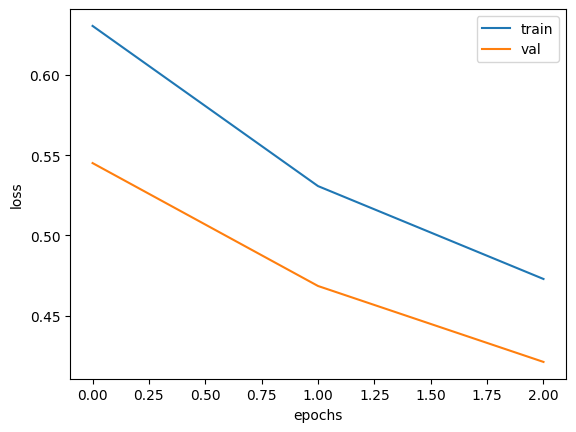

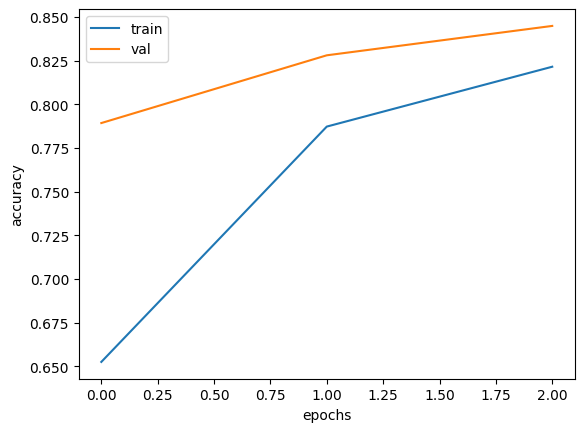

In [87]:
plt.plot(hist_model1_feature_based.history['loss'], label='train')
plt.plot(hist_model1_feature_based.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

plt.plot(hist_model1_feature_based.history['accuracy'], label='train')
plt.plot(hist_model1_feature_based.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.xlabel('epochs')


plt.legend()
plt.show()

67/67 [==============================] - 22s 162ms/step
Confusion Matrix:
 [[1035   85]
 [ 262  758]]
F1 Score: 0.8137412775093935
Accuracy: 0.8378504672897197


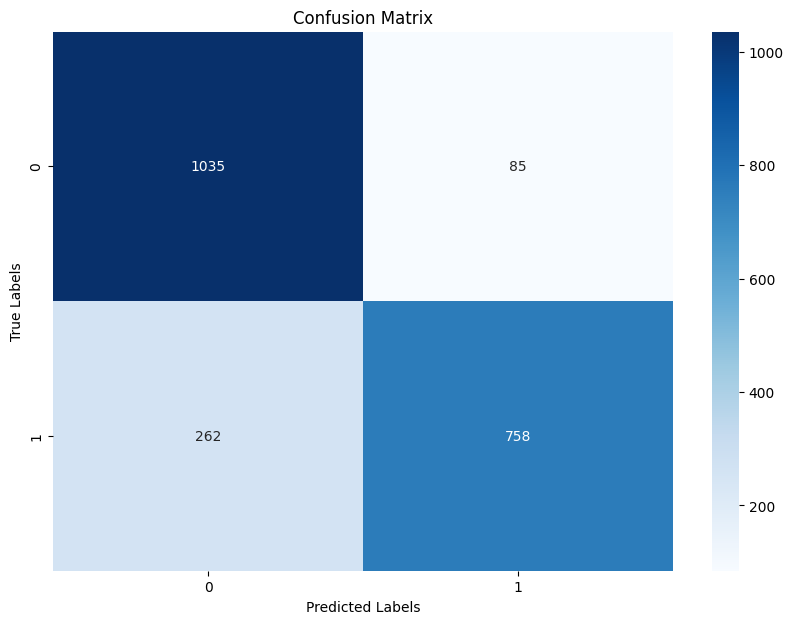

In [88]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

test_input_ids, test_attention_masks = encode_data(df_test, tokenizer)
test_labels = df_test['label'].values

raw_predictions = model1_feature_based.predict([test_input_ids, test_attention_masks])
predictions = tf.squeeze(tf.round(raw_predictions)).numpy()

conf_matrix = confusion_matrix(test_labels, predictions)

f1 = f1_score(test_labels, predictions)

accuracy = accuracy_score(test_labels, predictions)

print('Confusion Matrix:\n', conf_matrix)
print('F1 Score:', f1)
print('Accuracy:', accuracy)

import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# feature based model2

In [92]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

bert_model.trainable = False

def encode_data(df, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    
    for tweet in df['tweet']:
        encoded = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            truncation=True, 
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

train_input_ids, train_attention_masks = encode_data(df_train, tokenizer)
val_input_ids, val_attention_masks = encode_data(df_val, tokenizer)

train_labels = tf.convert_to_tensor(df_train['label'])
val_labels = tf.convert_to_tensor(df_val['label'])

input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')


bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]

gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=False))(bert_output)

dense = tf.keras.layers.Dense(1, activation='sigmoid')(gru_layer)
model_BiGRU_feature_based = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=dense)

model_BiGRU_feature_based.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
hist_model_BiGRU_feature_based = model_BiGRU_feature_based.fit([train_input_ids, train_attention_masks], train_labels,
          validation_data=([val_input_ids, val_attention_masks], val_labels),
          epochs=3,
          batch_size=4)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1605/1605 [==============================] - 110s 52ms/step - loss: 0.4117 - accuracy: 0.8369 - val_loss: 0.2902 - val_accuracy: 0.8846
Epoch 2/3
1605/1605 [==============================] - 71s 44ms/step - loss: 0.2545 - accuracy: 0.8997 - val_loss: 0.2147 - val_accuracy: 0.9103
Epoch 3/3
1605/1605 [==============================] - 71s 44ms/step - loss: 0.2047 - accuracy: 0.9160 - val_loss: 0.1870 - val_accuracy: 0.9224


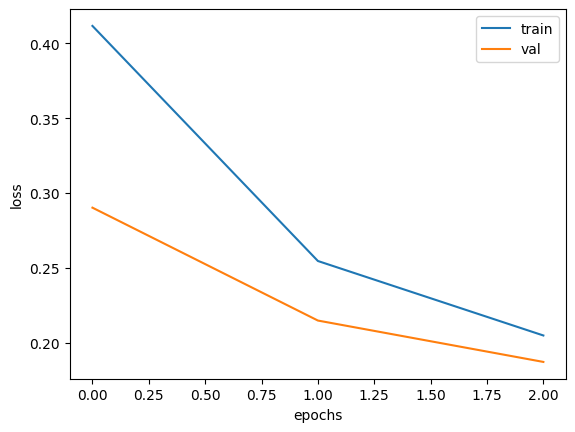

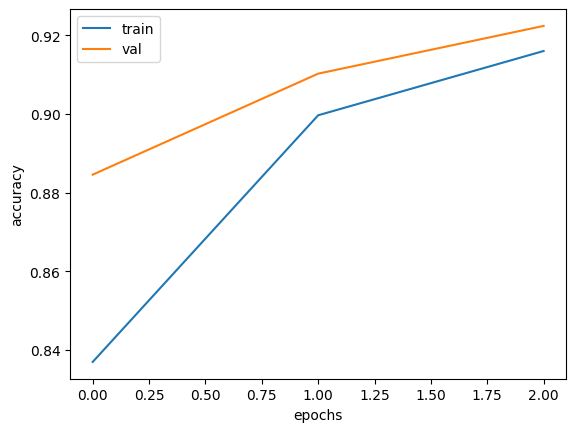

In [93]:
plt.plot(hist_model_BiGRU_feature_based.history['loss'], label='train')
plt.plot(hist_model_BiGRU_feature_based.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

plt.plot(hist_model_BiGRU_feature_based.history['accuracy'], label='train')
plt.plot(hist_model_BiGRU_feature_based.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.xlabel('epochs')


plt.legend()
plt.show()

67/67 [==============================] - 22s 166ms/step
Confusion Matrix:
 [[1065   55]
 [ 118  902]]
F1 Score: 0.9124936772888215
Accuracy: 0.9191588785046729


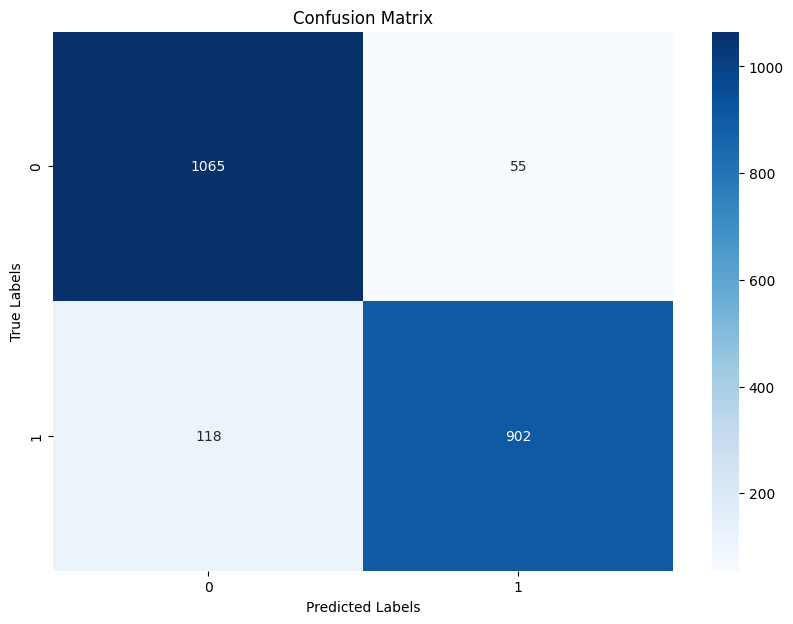

In [94]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

test_input_ids, test_attention_masks = encode_data(df_test, tokenizer)
test_labels = df_test['label'].values

raw_predictions2 = model_BiGRU_feature_based.predict([test_input_ids, test_attention_masks])
predictions2 = tf.squeeze(tf.round(raw_predictions2)).numpy()

conf_matrix = confusion_matrix(test_labels, predictions2)

f1 = f1_score(test_labels, predictions2)

accuracy = accuracy_score(test_labels, predictions2)

print('Confusion Matrix:\n', conf_matrix)
print('F1 Score:', f1)
print('Accuracy:', accuracy)

import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# feature based model 3

In [95]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert')
bert_model = TFBertModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert')

bert_model.trainable = False

def encode_data(df, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    
    for tweet in df['tweet']:
        encoded = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            truncation=True, 
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

train_input_ids, train_attention_masks = encode_data(df_train, tokenizer)
val_input_ids, val_attention_masks = encode_data(df_val, tokenizer)

train_labels = tf.convert_to_tensor(df_train['label'])
val_labels = tf.convert_to_tensor(df_val['label'])

input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]

gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=False))(bert_output)

dense = tf.keras.layers.Dense(1, activation='sigmoid')(gru_layer)
model3_CT_Bert_feature_based = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=dense)

model3_CT_Bert_feature_based.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Train the model
with tf.device('/GPU:0'):
    hist_model3_CT_Bert_feature_based = model3_CT_Bert_feature_based.fit([train_input_ids, train_attention_masks], train_labels,
                                             validation_data=([val_input_ids, val_attention_masks], val_labels),
                                             epochs=3,
                                             batch_size=4)




Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_ma

Epoch 1/3
1605/1605 [==============================] - 251s 126ms/step - loss: 0.3477 - accuracy: 0.8617 - val_loss: 0.1968 - val_accuracy: 0.9271
Epoch 2/3
1605/1605 [==============================] - 182s 113ms/step - loss: 0.1718 - accuracy: 0.9419 - val_loss: 0.1390 - val_accuracy: 0.9481
Epoch 3/3
1605/1605 [==============================] - 181s 113ms/step - loss: 0.1315 - accuracy: 0.9540 - val_loss: 0.1186 - val_accuracy: 0.9556


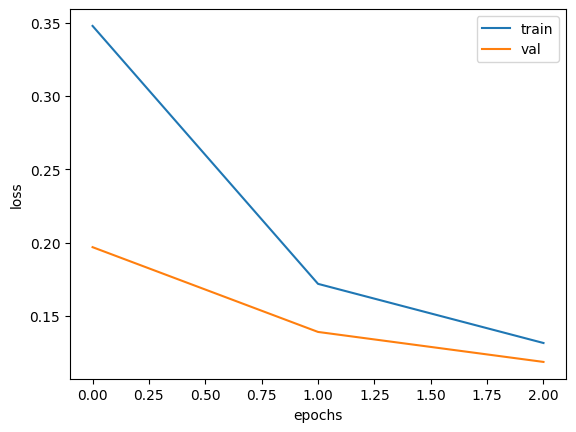

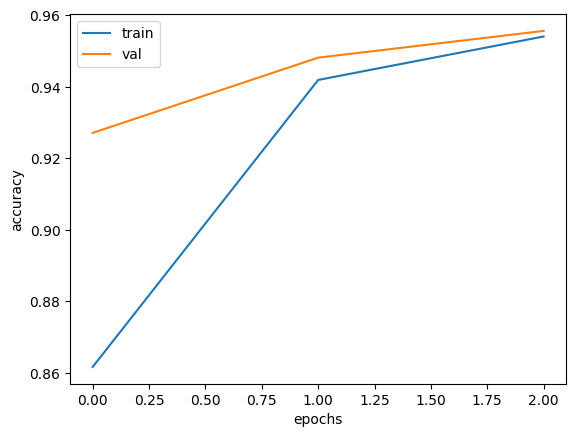

In [97]:
plt.plot(hist_model3_CT_Bert_feature_based.history['loss'], label='train')
plt.plot(hist_model3_CT_Bert_feature_based.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

plt.plot(hist_model3_CT_Bert_feature_based.history['accuracy'], label='train')
plt.plot(hist_model3_CT_Bert_feature_based.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.xlabel('epochs')


plt.legend()
plt.show()

67/67 [==============================] - 58s 504ms/step
Confusion Matrix:
 [[1085   35]
 [  56  964]]
F1 Score: 0.9549281822684497
Accuracy: 0.9574766355140187


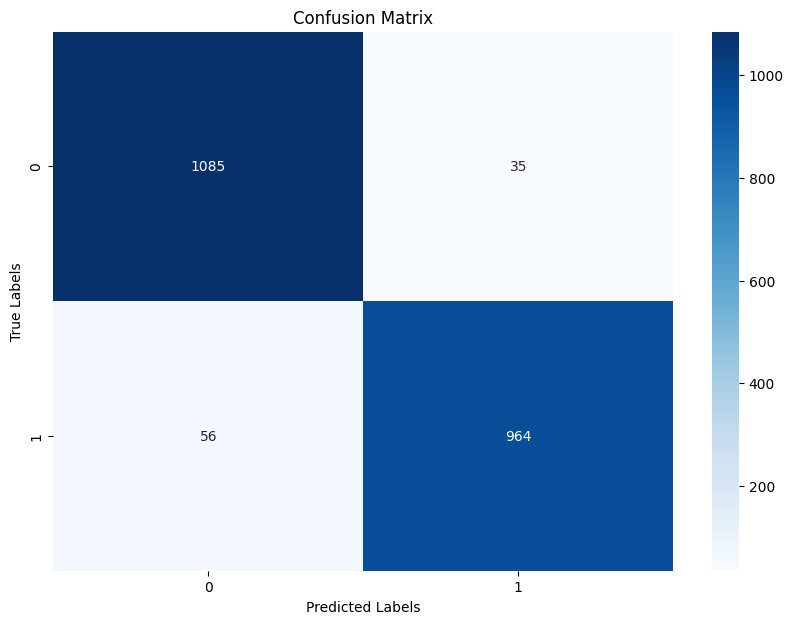

In [105]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

test_input_ids, test_attention_masks = encode_data(df_test, tokenizer)
test_labels = df_test['label'].values

raw_predictions3 = model3_CT_Bert_feature_based.predict([test_input_ids, test_attention_masks])
predictions3 = tf.squeeze(tf.round(raw_predictions3)).numpy()

conf_matrix = confusion_matrix(test_labels, predictions3)

f1 = f1_score(test_labels, predictions3)

accuracy = accuracy_score(test_labels, predictions3)

print('Confusion Matrix:\n', conf_matrix)
print('F1 Score:', f1)
print('Accuracy:', accuracy)

import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# see prediction model1 for test data

In [101]:
true_labels = df_test['label'].values

# Find indices of incorrect predictions
incorrect_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred != true]

print("Indices of incorrect predictions:", incorrect_indices)
      
      

Indices of incorrect predictions: [7, 12, 15, 24, 27, 30, 43, 45, 55, 60, 61, 65, 71, 79, 91, 94, 102, 104, 105, 118, 140, 144, 159, 162, 163, 171, 177, 180, 183, 184, 195, 199, 200, 205, 223, 226, 234, 239, 244, 245, 247, 256, 257, 261, 273, 276, 277, 281, 290, 301, 302, 306, 312, 319, 320, 325, 326, 335, 336, 349, 364, 367, 375, 378, 384, 392, 393, 404, 413, 417, 421, 431, 435, 439, 440, 452, 457, 460, 466, 467, 469, 471, 473, 475, 479, 480, 487, 491, 503, 507, 520, 521, 525, 538, 540, 545, 556, 557, 572, 586, 588, 589, 601, 613, 620, 621, 622, 625, 626, 638, 645, 649, 657, 659, 665, 668, 691, 692, 695, 698, 709, 712, 713, 716, 728, 731, 734, 745, 764, 768, 782, 783, 796, 798, 802, 804, 805, 811, 818, 824, 827, 830, 832, 835, 847, 852, 858, 863, 865, 869, 873, 888, 889, 892, 909, 917, 927, 944, 947, 949, 957, 962, 963, 965, 973, 975, 976, 990, 994, 997, 1003, 1008, 1014, 1020, 1022, 1023, 1028, 1032, 1034, 1041, 1054, 1057, 1063, 1067, 1069, 1077, 1081, 1089, 1092, 1093, 1097, 1099, 

In [114]:
print("sentence1 :",df_test['tweet'][7])
print("sentence2 :",df_test['tweet'][12])

sentence1 : The government should consider bringing in any new national lockdown rules over Christmas rather than now says an Oxford University professor https://t.co/pdOls6cqoN
sentence2 : :Kuwait: Assistant Undersecretary for Public Health Affairs Dr Buthayna Almodaf highlighted the importance of risk communication &amp; public education in fighting #COVID19. The country increased testing capacity enabling 400000 people to be tested.


# predict  labels for model2

In [103]:
true_labels = df_test['label'].values

# Find indices of incorrect predictions
incorrect_indices2 = [i for i, (pred, true) in enumerate(zip(predictions2, true_labels)) if pred != true]

# Print incorrect indices
print("Indices of incorrect predictions:", incorrect_indices2)
      
      

Indices of incorrect predictions: [10, 12, 16, 27, 45, 55, 91, 159, 180, 181, 183, 184, 186, 195, 231, 233, 240, 256, 267, 277, 290, 302, 306, 312, 319, 320, 336, 349, 358, 367, 385, 413, 435, 439, 466, 469, 487, 503, 512, 520, 525, 526, 536, 540, 557, 562, 589, 595, 613, 638, 642, 655, 657, 668, 682, 691, 695, 705, 717, 720, 728, 764, 782, 783, 787, 811, 824, 844, 867, 869, 873, 882, 888, 889, 909, 927, 944, 947, 957, 959, 975, 997, 1022, 1023, 1032, 1034, 1057, 1067, 1093, 1099, 1110, 1134, 1135, 1142, 1145, 1169, 1172, 1183, 1190, 1217, 1231, 1235, 1249, 1251, 1264, 1280, 1289, 1332, 1344, 1354, 1369, 1403, 1416, 1418, 1428, 1437, 1457, 1460, 1469, 1473, 1481, 1504, 1521, 1528, 1529, 1541, 1579, 1582, 1598, 1603, 1604, 1614, 1631, 1648, 1649, 1672, 1689, 1703, 1704, 1715, 1725, 1733, 1769, 1795, 1799, 1806, 1807, 1829, 1830, 1832, 1843, 1860, 1879, 1889, 1903, 1937, 1940, 1983, 1996, 2015, 2029, 2044, 2067, 2082, 2085, 2093, 2108, 2111, 2117, 2119, 2124, 2132, 2133]


In [113]:
print("sentence1 :",df_test['tweet'][10])
print("sentence2 :",df_test['tweet'][12])

sentence1 : Two interesting correlations:

1) Children tend to weather COVID-19 pretty well; they also get a ton of Vitamin D.

2) Black people are getting slammed by COVID-19; black people also have much higher instances of Vitamin D deficiency (76% vs 40% in the general population).
sentence2 : :Kuwait: Assistant Undersecretary for Public Health Affairs Dr Buthayna Almodaf highlighted the importance of risk communication &amp; public education in fighting #COVID19. The country increased testing capacity enabling 400000 people to be tested.


# predicts labels for model3

In [106]:
true_labels = df_test['label'].values

# Find indices of incorrect predictions
incorrect_indices3 = [i for i, (pred, true) in enumerate(zip(predictions3, true_labels)) if pred != true]

# Print incorrect indices
print("Indices of incorrect predictions:", incorrect_indices3)
      
      

Indices of incorrect predictions: [7, 27, 45, 61, 102, 151, 181, 183, 184, 189, 195, 231, 267, 277, 302, 322, 349, 367, 385, 413, 466, 469, 526, 536, 540, 546, 549, 561, 595, 597, 645, 655, 661, 705, 809, 827, 869, 902, 909, 947, 975, 986, 1057, 1067, 1099, 1105, 1124, 1160, 1169, 1172, 1179, 1191, 1217, 1228, 1230, 1231, 1235, 1249, 1251, 1287, 1289, 1314, 1315, 1366, 1369, 1409, 1414, 1424, 1457, 1473, 1528, 1541, 1564, 1579, 1604, 1614, 1631, 1655, 1699, 1778, 1795, 1843, 1879, 1905, 1920, 1924, 1937, 1971, 2044, 2067, 2110]


In [112]:
print("sentence1 :",df_test['tweet'][7])
print("sentence2 :",df_test['tweet'][27])


sentence1 : The government should consider bringing in any new national lockdown rules over Christmas rather than now says an Oxford University professor https://t.co/pdOls6cqoN
sentence2 : Govt has added #Corona disease in all existing mediclaim insurances as a special case

#COVID2019India https://t.co/39vpW7tBqq
